In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import json
from PIL import Image, ImageDraw
from image_gen_aux import DepthPreprocessor
from diffusers import FluxControlPipeline, FluxPriorReduxPipeline, FluxFillPipeline
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from models.attention_processor import FluxAttnProcessor2_0_my
from utils import downsample_mask, mask_sym_attn

In [3]:
processor = DepthPreprocessor.from_pretrained("/amax/hchuz/hfd_models/depth-anything-large-hf")
pipe_prior_redux = FluxPriorReduxPipeline.from_pretrained("black-forest-labs/FLUX.1-Redux-dev", torch_dtype=torch.bfloat16).to('cuda')

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# control
model_id = "black-forest-labs/FLUX.1-dev"
pipe = FluxControlPipeline.from_pretrained(model_id, 
                                            text_encoder=None,
                                            text_encoder_2=None,
                                            torch_dtype=torch.bfloat16)
#pipe.enable_model_cpu_offload()
pipe.to('cuda')
pipe.load_lora_weights("/amax/hchuz/hfd_models/FLUX.1-Depth-dev-lora", adapter_name="depth")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [5]:
# paras
pipe.set_adapters("depth", 1.0)
if 'dev' in model_id:
    kwargs = {
            'guidance_scale':2.5,
            'num_inference_steps':20,
        }
else:
    kwargs={
        'guidance_scale':0,
        'num_inference_steps':4
    }

In [6]:
name = 'Snipaste_2023-02-21_13-33-06'
with open(os.path.join('相似的几个2', f'{name}.json'), 'r') as f:
    data = json.load(f)
data.keys()

dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])

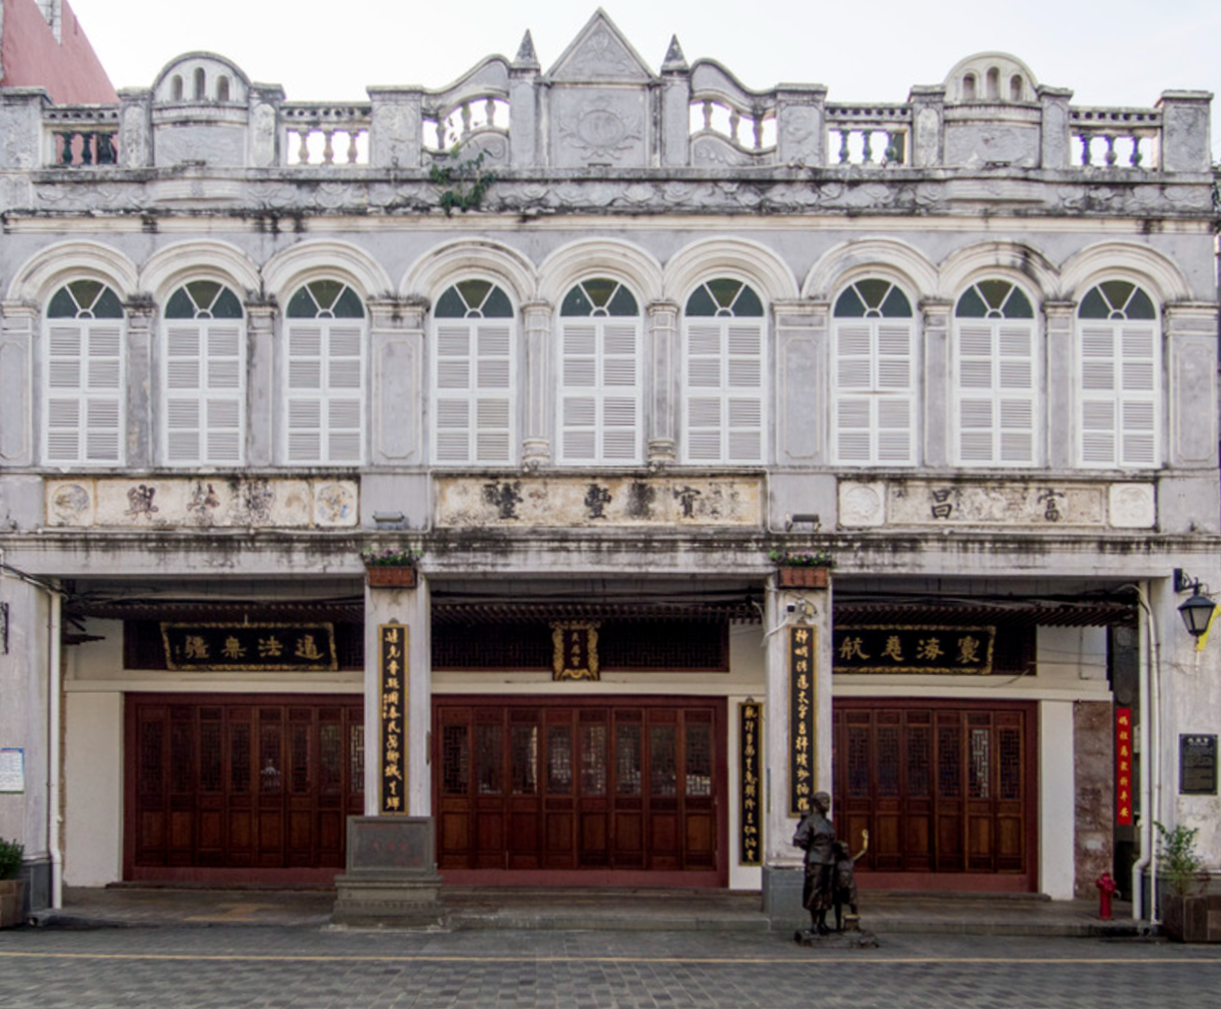

In [7]:
control_image = Image.open(os.path.join('相似的几个2', f'{name}.png')).convert('RGB')
control_image

In [8]:
control_image_ = processor(control_image)[0].convert("RGB")

In [9]:
sample = data['shapes'][20]
points = sample['points']
print(sample['label'])
points

window


[[1075.6492127481424, 303.745435076231],
 [1079.2685387153158, 295.9983845846907],
 [1087.011720705439, 286.69987080147115],
 [1094.33027459457, 281.0124550768392],
 [1103.8347803931813, 276.9161257773334],
 [1117.6271948279043, 275.15336703425794],
 [1132.928931411969, 277.65521555197773],
 [1144.2241642397196, 283.0505772336717],
 [1152.4201495704572, 291.8524131550527],
 [1158.1210266921255, 301.75535936920187],
 [1161.7262785909693, 312.75860215071714],
 [1160.4229615245024, 356.9511002094358],
 [1160.1215528999576, 467.35246151339334],
 [1073.0672391578264, 466.49424374290504],
 [1074.0924366756901, 352.3143189331476],
 [1074.0938862813496, 316.6541309989773]]

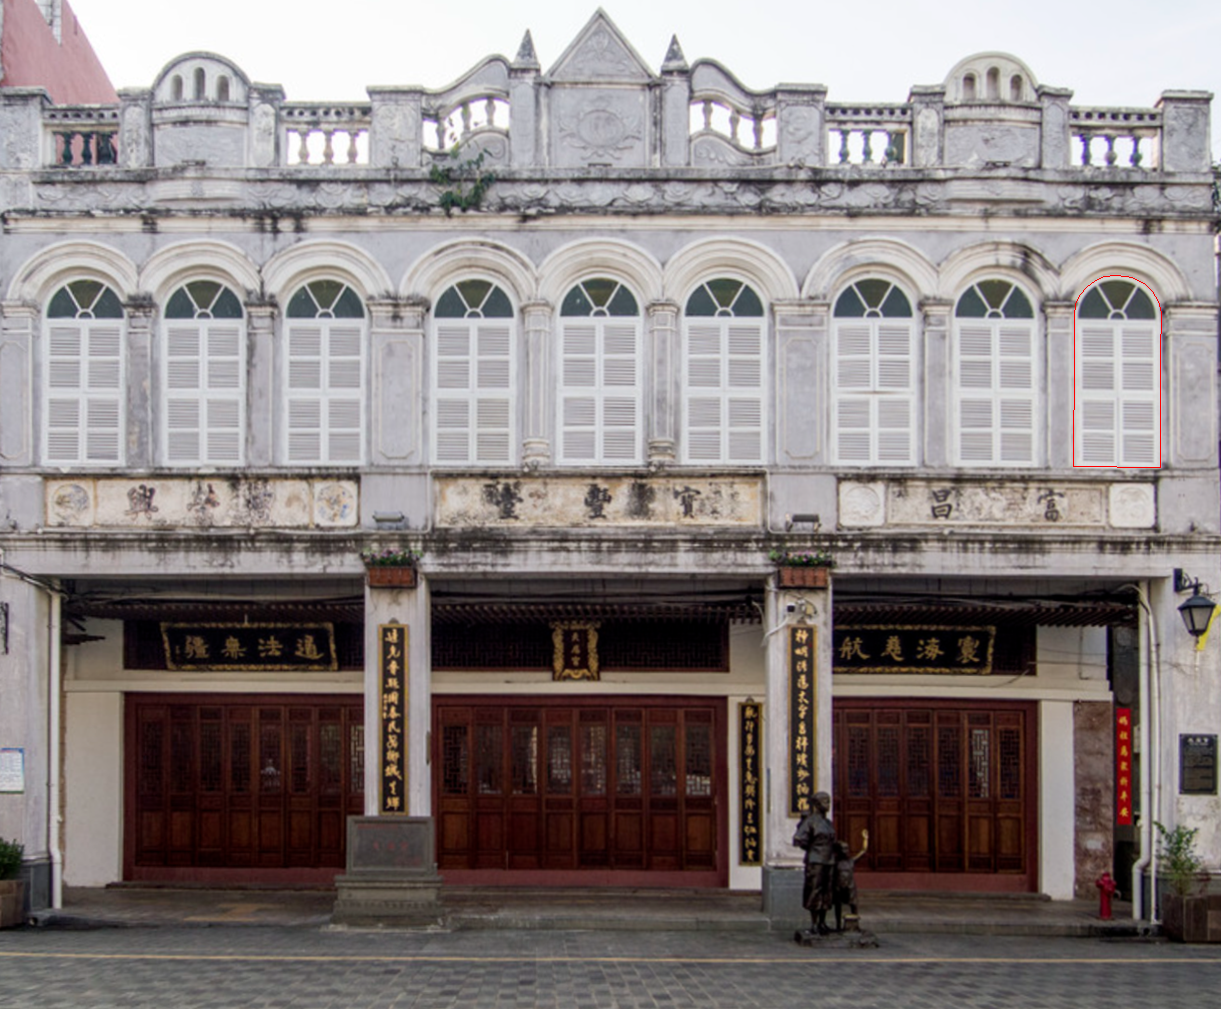

In [10]:
image_vis = control_image.copy()
draw = ImageDraw.Draw(image_vis)
polygon_points_int = [(int(point[0]), int(point[1])) for point in points]
draw.polygon(polygon_points_int, fill=None, outline=(255, 0, 0))
image_vis

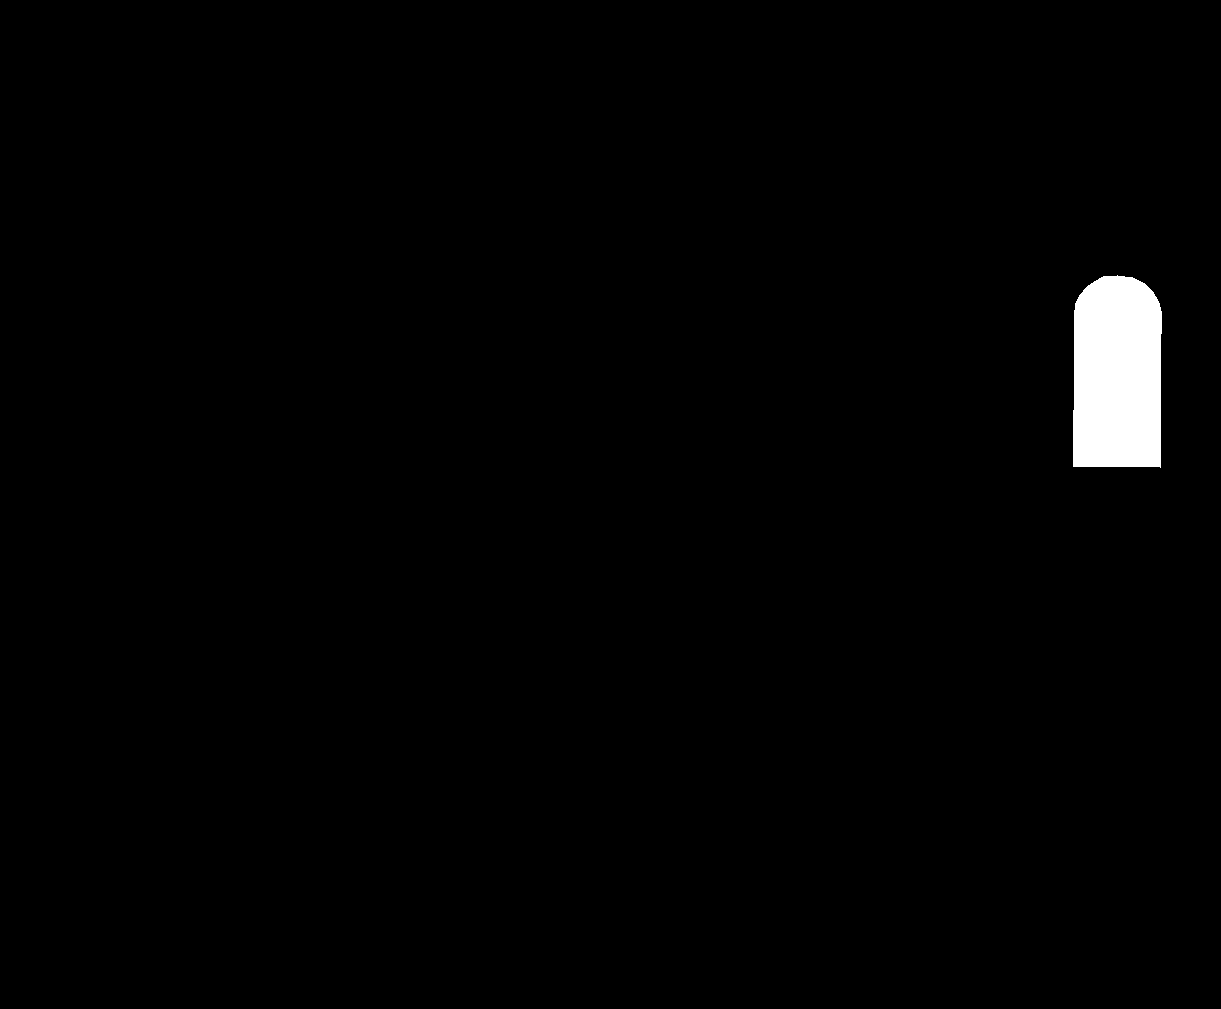

In [11]:
mask_image = Image.new('L', (control_image.width, control_image.height), 0)
draw = ImageDraw.Draw(mask_image)
polygon_points_int = [(int(point[0]), int(point[1])) for point in points]
draw.polygon(polygon_points_int, fill=255)
mask_image

In [12]:
name2 = 'Snipaste_2023-02-21_13-33-51'
with open(os.path.join('相似的几个2', f'{name2}.json'), 'r') as f:
    data2 = json.load(f)

window


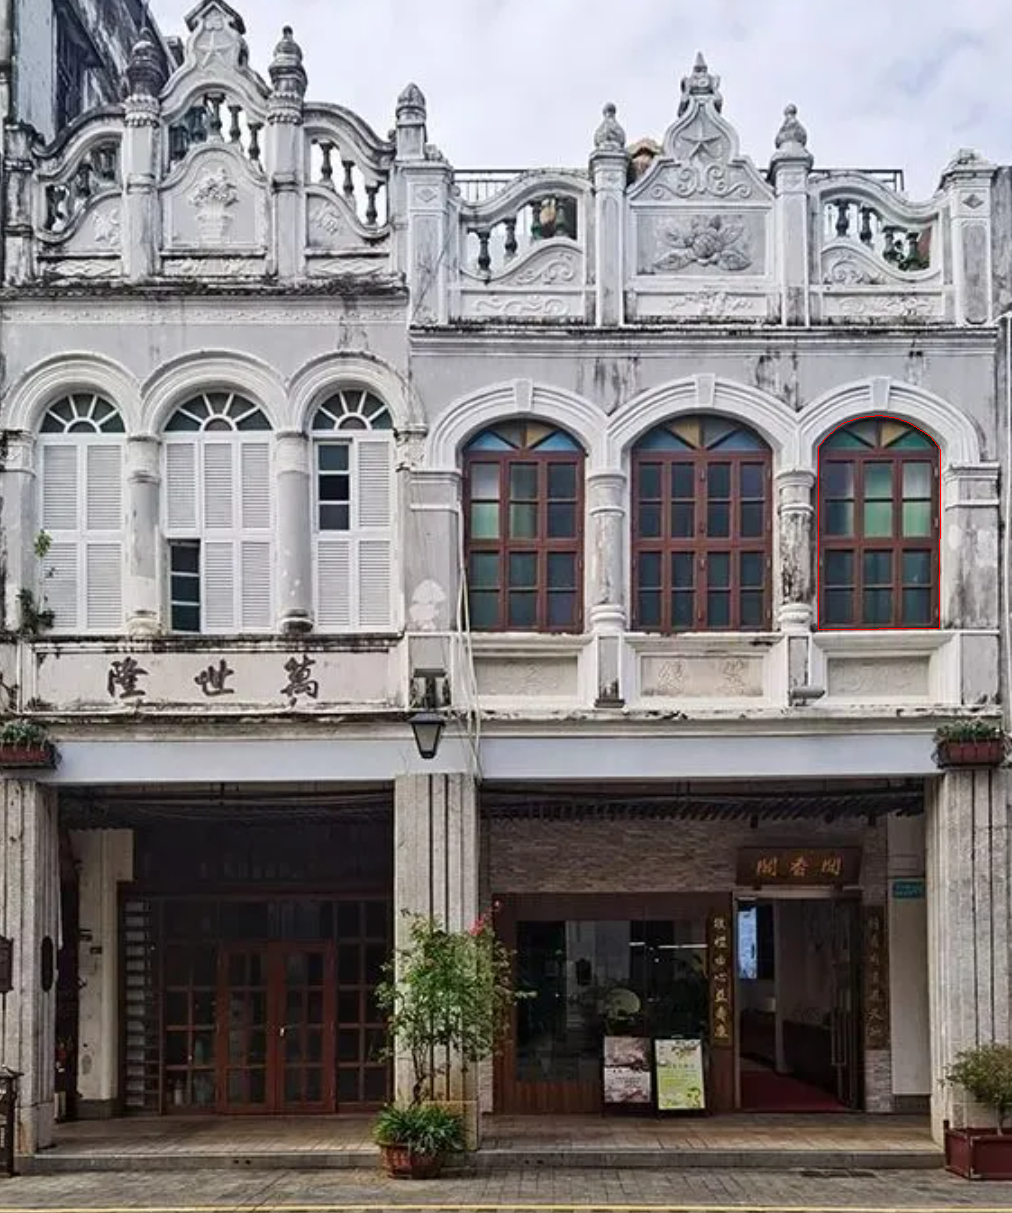

In [13]:
control_image2 = Image.open(os.path.join('相似的几个2', f'{name2}.png')).convert('RGB')
sample = data2['shapes'][17]
points = sample['points']
print(sample['label'])
image_vis = control_image2.copy()
draw = ImageDraw.Draw(image_vis)
polygon_points_int = [(int(point[0]), int(point[1])) for point in points]
draw.polygon(polygon_points_int, fill=None, outline=(255, 0, 0))
image_vis

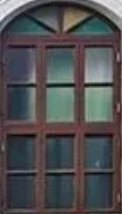

In [14]:
x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]

# 找到最小和最大值
min_x = min(x_coords)
max_x = max(x_coords)
min_y = min(y_coords)
max_y = max(y_coords)

# 输出结果
box = (min_x, min_y, max_x, max_y)
style_image = control_image2.crop(box)
style_image

In [15]:
pipe.transformer.set_attn_processor(FluxAttnProcessor2_0_my())

In [ ]:
def attn_mask_preprocess(chars, height, width, pipe_prior_redux, masks=None, chars_mask=None, **kwargs):
    # prepare mask and paras
    num_img_tokens = (height // 16) * (width // 16)
    if masks != None:
        masks_ds = [downsample_mask(mask, num_img_tokens).bool().squeeze().flatten() for mask in masks]
    #max_sequence_length = kwargs['max_sequence_length']

    # encode character info and maybe crop
    chars_emb = [pipe_prior_redux(char) for char in chars]
    chars_emb_proc = [char_emb['prompt_embeds'][:,512:,:] for char_emb in chars_emb]
    if chars_mask != None:
        chars_emb_proc = [char_emb_proc*downsample_mask(char_mask.to(torch.float), 729).squeeze().bool().flatten()[None,:,None].to('cuda') for char_emb_proc, char_mask in zip(chars_emb_proc, chars_mask)]
    chars_emb_proc = [torch.cat([char_emb['prompt_embeds'][:,:512,:], char_emb_proc], dim=1) for char_emb_proc, char_emb in zip(chars_emb_proc, chars_emb)]
    
    # encode prompt info
    # prompt_embeds, pooled_prompt_embeds, _ = self.pipe.encode_prompt(prompt, prompt_2=None, max_sequence_length=max_sequence_length)
    num_ref_img_tokens = chars_emb_proc[0].shape[1]
    num_ref_img = len(chars)
    prompt_embeds = torch.cat([char_emb_proc for char_emb_proc in chars_emb_proc], dim=1)

    # prepare attention_mask to forbid some attn
    total_tokens = num_ref_img * num_ref_img_tokens + num_img_tokens
    attention_mask = torch.ones(1, total_tokens, total_tokens, dtype=torch.bool, device=prompt_embeds.device)
    count_num_ref = 1
    if masks != None:
        for mask_ds in masks_ds:
            mask_sym_attn(attention_mask, slice(None if count_num_ref==1 else (count_num_ref-1)*num_ref_img_tokens, count_num_ref*num_ref_img_tokens), slice(-num_img_tokens, None), mask_ds)
            #mask_sym_attn(attention_mask, slice(-num_img_tokens, None), slice(-num_img_tokens, None), mask_ds)
            count_num_ref += 1
    
    # mask ref imgs
    #mask_sym_attn(attention_mask, slice(0, num_ref_img_tokens), slice(num_ref_img_tokens, 2*num_ref_img_tokens), False)
    
    return {'prompt_embeds':prompt_embeds,
            'pooled_prompt_embeds':torch.zeros((1,768)).to(prompt_embeds.device, prompt_embeds.dtype),
            'joint_attention_kwargs': {'attention_mask': attention_mask}}

In [30]:
region_mask = torch.from_numpy(np.array(mask_image)).bool()
full_mask = torch.ones((1, control_image.height, control_image.width)).bool()
masks = [full_mask.float(), (full_mask & ~region_mask).float()]
kwargs_mask = attn_mask_preprocess([control_image, style_image], control_image.height, control_image.width, pipe_prior_redux, masks)

In [31]:
kwargs.update(kwargs_mask)

`height` and `width` have to be divisible by 16 but are 1009 and 1221. Dimensions will be resized accordingly


  0%|          | 0/20 [00:00<?, ?it/s]

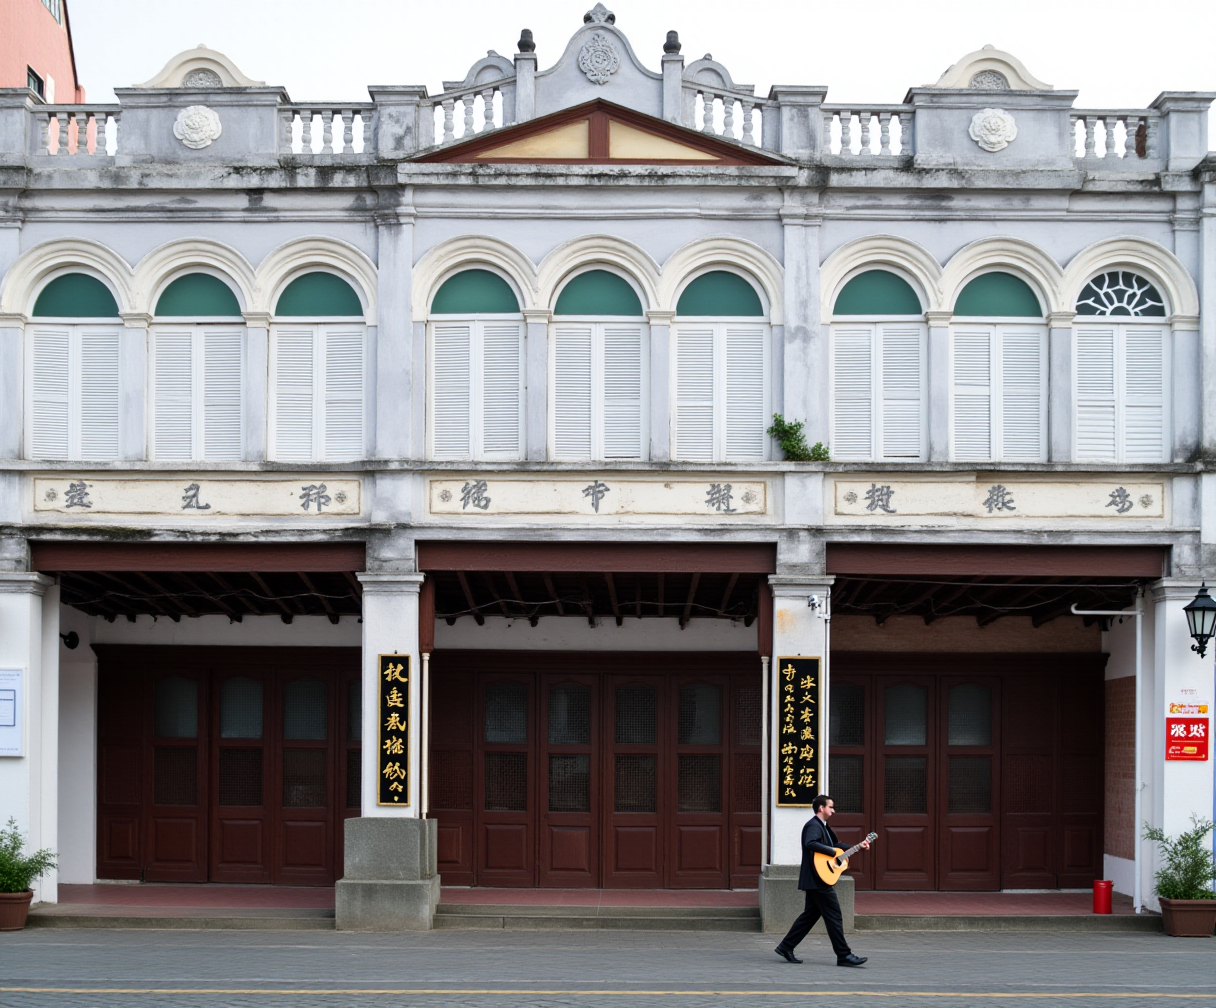

In [32]:
#seed = random.randint(0,10000)
seed = 4803
#pipe_prior_output = pipe_prior_redux(control_image)
image = pipe(
    **kwargs,
    control_image=control_image_,
    height = control_image.height,
    width = control_image.width,
    generator=torch.Generator("cpu").manual_seed(seed),
    #**pipe_prior_output,
).images[0]
image